# **Objective**
***

In this lab session, we will be exploring a quantum approach to the classical learning algorithm $\cal{k}$-Means Clustering. The aim of this algorithm is to take a large set of raw data and organize each data point as belonging to one of $\cal{k}$ groupings, called clusters. The quantum analogue to this algorithm, $\cal{Q}$-Means Clustering, will look to replace one the bottleneck of the classical algorithm, namely calculating distances between data points. At its core, this quantum distance calculating process will make use of a powerful subroutine: the SWAP Test, for which we will be delving deeply into.



In order to make sure that all cells of code run properly throughout this lab session, please run the following cell of code below:



In [6]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute
import numpy as np
import math as m
import scipy as sci
import random
import time
import matplotlib
import matplotlib.pyplot as plt
from itertools import permutations
S_simulator = Aer.backends(name='statevector_simulator')[0]

/var/folders/jc/kp4xhk952mn13_g04my_yqwh0000gn/T/ipykernel_2938/4228218805.py:10: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  S_simulator = Aer.backends(name='statevector_simulator')[0]


# **Analyzing Data Into Groups**
***

In our modern era of smartphones, computers, etc., some of the most sought after algorithms are those which handle enormous amounts of data. Collecting data is easy, but making good use of it is tricky. So much so in fact that we've seen the rise of an entire field of science, "Data Scientists'', who specialize solely in the advancement of techniques for handling data. And while classical computers have steadily been getting faster, their limits are starting to become clearer, and the need for new fundamental techniques are required if we want to tackle larger and more complex data analyzing problems.

When analyzing large sets of data, oftentimes we would like to categorically group data points of similar nature into what are known as "clusters", which in turn allows us to interpret, predict, and make use of the data in a much more compact manner. An example of this may include medical studies, whereby each individual person and their unique health conditions makes up a data point, and the goal is to categorically group people of similar dispositions to better prepare them for various potential health risks. Once enough data points have been properly sorted into clusters, allowing for a fast and efficient high-level interpretation of the data, newer points of data can then be quickly sorted in and analyzed. In the medical field, this can lead to life-saving decisions for patients who show health trends similar to previous cases.

In this lab session, we will be focusing on a very well known data analyzing algorithm, $\cal{k}$-means clustering, first published by <!-- [Text](link) -->
[Stuart Llyod in 1982](https://ieeexplore.ieee.org/document/1056489 "Optional Title"), but developed over two decades prior. Mathematically, the core of this algorithm boils down to interpreting data points through calculating Euclidean distances:

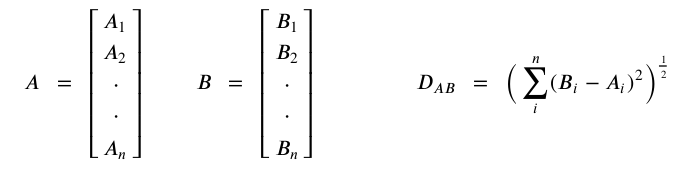

where the goal is to find a central point, known as a "centroid", which minimizes the distance from each point within the cluster:

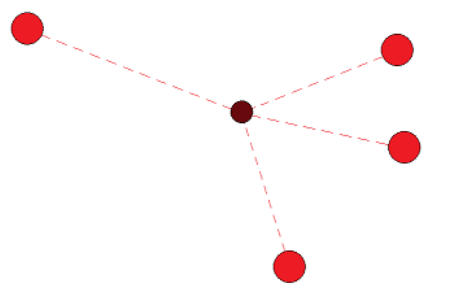

As illustrated above, the dark red point represents the centroid to our cluster. The dashed lines represent each data point's distance to the centroid, $D_{ij}$, whose sum we want to minimize. When calculating the centroid for a set of N points, one approach is to use the mean x and y values computed from all of the data points making up the cluster:

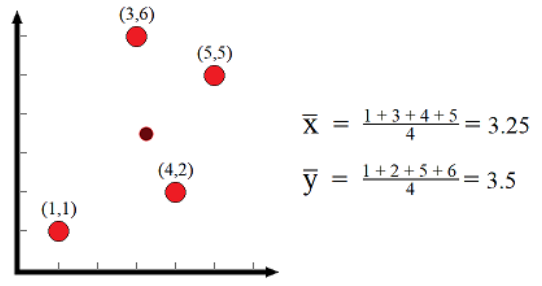

As shown in the example above, using the mean x and y values from all of the points in the cluster gives us a centroid that appears to be quite central.
However, it turns out that computing a centroid in this manner does **not**
give us the true center of our cluster (by which we mean minimizing the sum of
distances $D_{ij}$). Instead, centroids computed using mean coordinate values minimize the total **squared** Euclidean distance i.e. $\sum_{i}^{N} D_{ij}^{2}$.

To illustrate this difference, below is a quick code which exhaustively searches for the centroid points which minimize the sums of $D_{ij}$ versus
$D_{ij}^{2}$ corresponding to the example above:

In [7]:
Data = [ [1,1],[4,2],[5,5],[3,6] ]
D_min = [1000,0,0]
D2_min = [1000,0,0]
# -----------------------------------------Searches for centroids within 3 < x < 4 and 3 < y < 4
for i in np.arange(1000):
    X = 3.0 + i/1000.0
    for j in np.arange(1000):
        Y = 3.0 + j/1000.0
        D = 0
        D2 = 0
    for k in np.arange( len(Data) ):
        D = D + m.sqrt( (X-Data[k][0])**2 + (Y-Data[k][1])**2 )
        D2 = D2 + (X-Data[k][0])**2 + (Y-Data[k][1])**2
    if( D < D_min[0] ):
        D_min = [ D, X, Y ]
    if( D2 < D2_min[0] ):
        D2_min = [ D2, X, Y ]
#-----------------------------------------
print('Minimum Distance:',round(D_min[0],2),'coordinates: (',D_min[1],D_min[2],')')
print('Minimum Distance Squared: ',round(D2_min[0],2),'coordinates: (',D2_min[1],D2_min[2],')')

Minimum Distance: 9.82 coordinates: ( 3.654 3.999 )
Minimum Distance Squared:  26.75 coordinates: ( 3.25 3.999 )


As shown in the final answer to our code, the centroid computed using the mean coordinate values is indeed the location which minimizes the sum of $D_{ij}^{2}$, but not $D_{ij}$.

Now presented with this difference, the natural first question to ask is: is this a problem? **Does the success of our algorithm critically depend on
finding centroids which minimize total Euclidean distance, or is distance squared sufficient?**

The short answer: not a problem at all. Working with centroids calculated from means is an entirely viable approach to data analysis (you probably suspected this answer, hence the name $\cal{k}$-means clustering).

In fact, there is an equally efficient algorithm known as $\cal{k}$-medians clustering, which you guessed it, uses median coordinate values to compute cluster centroids. When using either approach, the important thing to note is the way in which we are able to efficiently represent a large group of data points with a single centroid, with relatively minimal computing power.

By comparison, note how the coding example above went about computing the centroid that minimized $D_{ij}$, searching exhaustively within a given area for the optimal point. If our algorithm critically depended on this centroid, we would be in trouble, as the computing overhead would be too much for even realistically small data sets.

## **K Clusters**


Moving right along with our $\cal{k}$-means algorithm, representing an entire data set with a single centroid is nice, but is it helpful? Perhaps unsurprisingly, categorizing every data point into a single cluster isn't very useful, so our next step will be to group all of our data into $\cal{k}$ different clusters.

The question then becomes, **which data points should belong to each cluster?**

Ideally we want to again minimize the distance (squared) of each data point to it's associated cluster centroid, but the challenge lies in determining which data points should contribute to which cluster. For example, take a look at the scatter plot of raw data below and think about how best to separate each point into one of two groups:

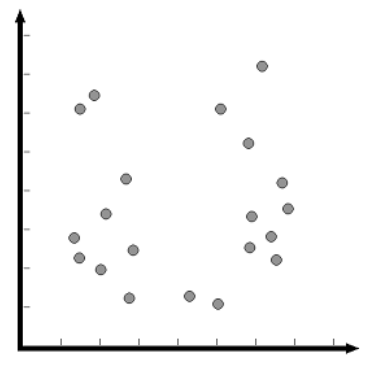

Visually, your eye may have a hunch as to the general shape of each potential cluster, but mathematically we need a way to be sure. Consider the two groupings below, each one representing a different interpretation of the same data:

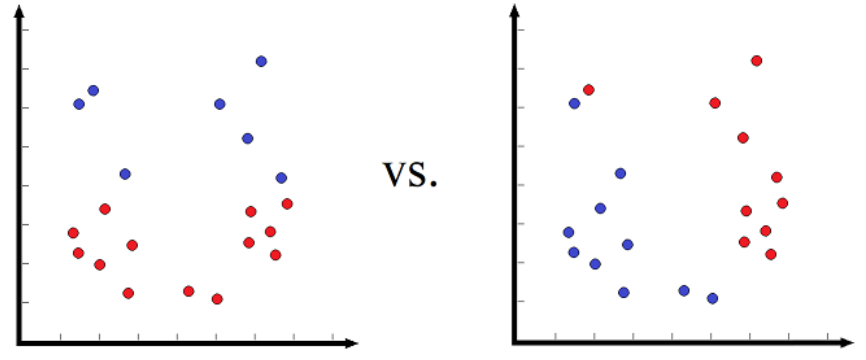

Sometimes 'eyeballing' the data can lead to good first intuitions about potential clusters, but in general there is no perfect methodology for solving this problem in one go. That is to say, there is no magical algorithm which can take in a complete set of data like the one shown above and perfectly sort it into $\cal{k}$ clusters of similar data points.

Thus, like many problems which can't be solved in a single step, our $\cal{k}$-means algorithm will solve our cluster sorting problem iteratively. More specifically, each step of the algorithm will analyze all the data points and update each cluster and centroid accordingly.

# **The $\cal{k}$-Means Clustering Algorithm**
***
As demonstrated in the previous section, we have the mathematical means for computing centroids with relative ease, but our problem lies in determining which data points to use for our $\cal{k}$ clusters. More specifically, to begin our algorithm we need to select initial $\cal{k}$ centroids, which in turn determine our initial clusters. 

As you might imagine though, where we choose to place our initial centroids can lead to drastically different clusters. Luckily, as we shall see in the
coming demonstrations, the final answer provided by the $\cal{k}$-means algorithm is only minimally influenced by our initial choices. Thus, for our implementation of the $\cal{k}$-means algorithm in this lesson, we will be following a first step guess of centroids known as the Forgy method. 

Since we have no a prori information about the optimal structure of our clusters, we will simply pick points out of our data set at random and treat them as our first centroids. From there, the iterative flow of the algorithm works as follows:

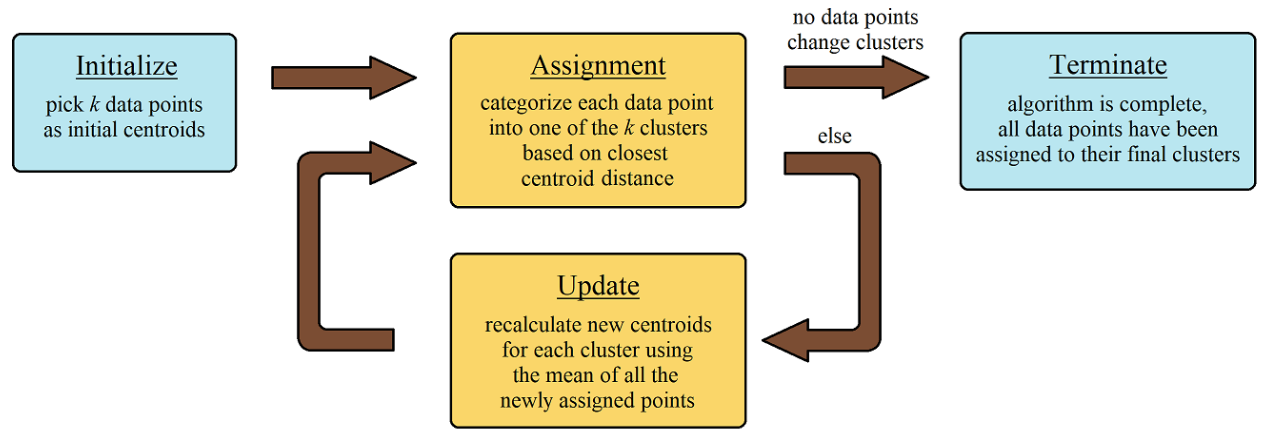

As shown above, the core of the algorithm is a back and forth flow between the **"Assignment" and "Update"** steps. After picking our initial $\cal{k}$ centroids, by whichever means we choose, the algorithm then proceeds iteratively until finally being terminated after there are no changes in any of the data points.

It's important to note that this process is not guaranteed to always terminate to the same final centroids / clusters. Although their influence is small, our final answer will have some remnants of the initial $\cal{k}$ data points which were chosen at random.

While this isn't problematic for the centroids, whose final values
may differ slightly, ideally it would be nice if the algorithm were to always group the data points into the same final clusters, regardless of initial conditions. However, since this isn't a guarantee, one must always keep in mind that rerunning the algorithm again may lead to different classifications on some
borderline points. That being said, overall the algorithm is quite stable, and in general will always lead to very similar final clusters, with only a small
percentage of points that may differ from run to run.

For our lab session here, **the implementation of this classical unsupervised learning algorithm, as outlined above, is all we need in order to appreciate the quantum version to come.**

Remember, our true aim is to see how we can use our quantum computer to improve the bottleneck step of $\cal{k}$-means clustering, which can then be
implemented into simple / advanced clustering algorithms alike.

In [8]:
# These functions are used to impliment k-Means in the next code block  
# Function 1
def k_Data(k,n):
  '''
  Input:
  k (integer)
  n (ineger)
  Creates a random set of data loosely centered around k locations
  '''
  Centers = []
  for i in np.arange(k):
    Centers.append( [1.5+np.random.rand()*5,1.5*random.random()*5] )
  count = round((0.7*n)/k)
  Data = []
  for j in np.arange(len(Centers)):
    for j2 in np.arange(count):
      r = random.random()*1.5
      Data.append( [ Centers[j][0]+r*np.cos(random.random()*2*m.pi) , Centers[j][1]+r*np.sin(random.random()*2*m.pi)])
  diff = int( n - k*count)
  for j2 in np.arange(diff):
    Data.append( [random.random()*8,random.random()*8] )
  return Data


# Function 2

def Initial_Centroids(k, D):
  '''
  Input:
  k (integer)
  D (array)
  Picks k data points at random from the list D
  '''
  D_copy = []
  for i in np.arange( len(D) ):
    D_copy.append( D[i] )
  Centroids = []
  for j in np.arange(k):
    p = random.randint(0,int(len(D_copy)-1))
    Centroids.append( [ D_copy[p][0] , D_copy[p][1] ] )
    D_copy.remove( D_copy[p] )
  return Centroids


# Function 3

def Update_Centroids(CT, CL):
  '''
  Input:
  CT (array)
  CL (array)
  Based on the data within each cluster, computes and returns new Centroids using mean coordinate values
  '''
  old_Centroids = []
  for c0 in np.arange(len(CT)):
    old_Centroids.append(CT[c0])
  Centroids = []
  for c1 in np.arange(len(CL)):
    mean_x = 0
    mean_y = 0
    for c2 in np.arange(len(CL[c1])):
      mean_x = mean_x + CL[c1][c2][0]/len(CL[c1])
      mean_y = mean_y + CL[c1][c2][1]/len(CL[c1])
    Centroids.append( [ mean_x,mean_y ] )
  return Centroids, old_Centroids


# Function 4

def Update_Clusters(D, CT, CL):
  '''
  Input:
  D (array)
  CT (array)
  CL (array)
  Using all data points and Centroids, computes and returns the new array of Clusters
  '''
  old_Clusters = []
  for c0 in np.arange(len(CL)):
    old_Clusters.append(CL[c0])
  Clusters = []
  for c1 in np.arange( len(CT) ):
    Clusters.append( [] )
  for d in np.arange( len(D) ):
    closest = 'c'
    distance = 100000
    for c2 in np.arange( len(Clusters) ):
      Dist = m.sqrt( ( CT[c2][0] - D[d][0] )**2 + ( CT[c2][1] - D[d][1] )**2 )
      if( Dist < distance ):
        distance = Dist
        closest = int(c2)
    Clusters[closest].append( D[d] )
  return Clusters,old_Clusters


# Function 5

def Check_Termination(CL, oCL ):
  '''
  Input:
  CL (array)
  oCL (array)
  Returns True or False based on whether the Update_Clusters function has caused any data points to change clusters
  '''
  terminate = True
  for c1 in np.arange( len(oCL) ):
    for c2 in np.arange( len(oCL[c1]) ):
      P_found = False
      for c3 in np.arange( len(CL[c1]) ):
        if( CL[c1][c3] == oCL[c1][c2] ):
          P_found = True
      if( P_found == False ):
        terminate = False
  return terminate


# Function 6

def Draw_Data(CL, CT, oCT, fig, ax, colors, colors2 ):
  '''
  Input:
  CL (array)
  CT (array)
  oCT (array)
  fig (matplotlib figure)
  ax (figure subplot)
  colors (array of color strings)
  colors2 (array of color strings)
  Using the arrays Clusters, Centroids, and old Centroids, draws and colors each data point according to its cluster
  '''
  for j1 in np.arange( len(CL) ):
    ax.scatter( oCT[j1][0],oCT[j1][1], color='white', marker='s',s=80 )
  for cc in np.arange(len(CL)):
    for ccc in np.arange( len( CL[cc] ) ):
      ax.scatter( CL[cc][ccc][0],CL[cc][ccc][1], color=colors[cc],s=10 )
  for j2 in np.arange( len(CL) ):
    ax.scatter( CT[j2][0],CT[j2][1], color=colors2[j2], marker='x',s=50 )
  fig.canvas.draw()
  time.sleep(1)


/var/folders/jc/kp4xhk952mn13_g04my_yqwh0000gn/T/ipykernel_2938/3925363456.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Clustering Complete:  6  Iterations


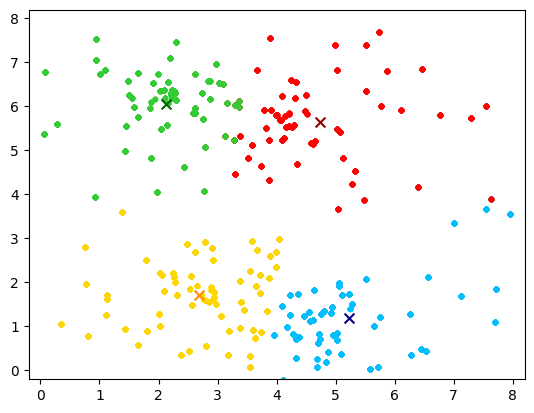

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.axis([-0.2,8.2,-0.2,8.2])
fig.show()
colors = ['red','limegreen','deepskyblue','gold']
colors2 = ['darkred','darkgreen','darkblue','darkorange']

#--------------------------------------------------------

N = 240
k = 4

#--------------------------------------------------------

Data = k_Data(k,N)              # Comment out this line after one run to reuse the same data points
for d in np.arange(len( Data )):
  ax.scatter( Data[d][0], Data[d][1], color='black', s=10 )
fig.canvas.draw()
time.sleep(2)

#--------------------------------------------------------

Centroids = Initial_Centroids( k, Data )
Clusters = []
Clusters,old_Clusters = Update_Clusters( Data, Centroids, Clusters )
for c1 in np.arange(len(Clusters)):
  for c2 in np.arange( len( Clusters[c1] ) ):
    ax.scatter( Clusters[c1][c2][0],Clusters[c1][c2][1], color=colors[c1],s=10 )
  ax.scatter( Centroids[c1][0],Centroids[c1][1], color=colors2[c1], marker='x',s=50 )
  fig.canvas.draw()
  time.sleep(1)
time.sleep(2)

#--------------------------------------------------------

terminate = False
iters = 0
while( (terminate==False) and (iters<50) ):
  Centroids,old_Centroids = Update_Centroids(Centroids, Clusters)
  Clusters,old_Clusters = Update_Clusters( Data, Centroids, Clusters )
  Draw_Data( Clusters, Centroids, old_Centroids, fig, ax, colors, colors2 )
  terminate = Check_Termination( Clusters, old_Clusters )
  iters = iters + 1
print( 'Clustering Complete: ',iters,' Iterations' )

I encourage you to try several runs, with varying values for N and $\cal{k}$, and see for yourself the various ways in which the algorithm propagates. Additionally, if you're curious about how the algorithm performs using the same data points but with differing initial centroids, try commenting out the k_Data(k,N) line after running the code once.


You may find that many of the borderline points between clusters fluctuate, but the overall location of the four centroids is consistent. If we think about how to interpret these fluctuations, it should make sense that borderline cases don't fully belong to one cluster or the other. In analyzing real-world data, the trickiest points to interpet are those which possess features of multiple distinct categories. For example, imagine we use our algorithm to determine TV show recommendations, and we want to categorize the new hit phenomenon "Baking  Explosions". One iteration of the algorithm might recommend the show to users who like "Cooking", while a second run might recommend it to people who enjoy "Action". Although a somewhat silly example, the point here is that in real data analysis there will always be borderline cases which shouldn't fully belong to just one cluster.

# **$\cal{k}$-Means $→$ $\cal{Q}$-Means Clustering**
***

Now that we have our baseline understanding of the classical $\cal{k}$-means algorithm, it's time to investigate where a quantum computer can lend a hand. Returning to the work flow diagram from earlier, we can see that the **majority of the runtime** for this particular algorithm is contained within the "Assignment" and "Update" steps. And in particular, it is the **"Assignment" step which is the most computationally costly**, requiring the calculation of distance between every point and every centroid. By contrast, the "Update" step is considerably quicker, which we already pointed out as the main advantage to using means as our methodology for computing centroids.

Diving a bit deeper into the computational cost of the "Assignment" step, we can say that the bottleneck of our algorithm lies in the sorting of each point into clusters, requiring the computation of $\cal{k}$ Euclidean distances per data point. Thus, if we are dealing with a data set of N points, each "Assignment" step will cost us $\cal{O}$(k*N) computations. Conversely, once all of the data points have been assigned to their respective clusters, the following "Update" step only requires $\cal{O}$(k) computations to generate the new centroids. 

This being the case, the natural first place to look for an algorithm improvement is in reducing the number of necessary distance calculations, or as we shall see, improve the speed at which we can calculate them!

## **Quantum Subroutine: The SWAP Test**

In order to properly discuss the role in which our quantum computer is going to provide us a speedup for the $\cal{k}$-means clustering algorithm, we will table our discussion of calculating Euclidean distances for now, and instead turn our attention to two subroutines, the first of which being "The SWAP Test". Now, we've seen the SWAP gate in previous sessions, and as a quick reminder, below is its circuit, matrix, and mathematical description:

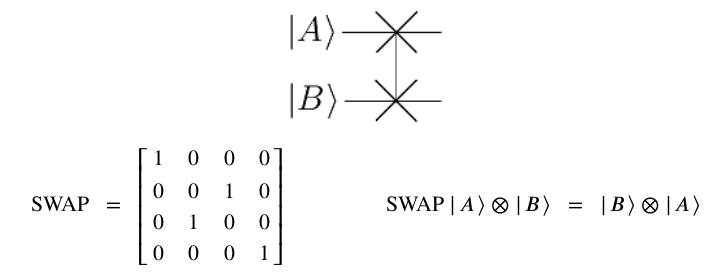

The effect of the SWAP gate is an easy one to remember, as it "swaps" two qubits' quantum states. With that in mind, there is a special case where the effect of the SWAP gate is mute, namely when $|{A}⟩ = |{B}⟩$. For the situation where two qubits possess the same quantum state, the action of a SWAP gate still
switches them, but the overall effect on the joint quantum system is unchanged. Although this may seem like a trivial point, it turns out to be the basis for the SWAP Test subroutine for which we are interested in.

Let's suppose we are given two single qubit quantum states $|Ψ⟩$ and $|Φ⟩$, and we are interested in how similar they are. Similar how, you might ask. Well, we can define our metric of similarity based around two extremes: $|Ψ⟩$ and $|Φ⟩$ are exactly the same state, or they are perfectly orthogonal. Mathematically, this means that our measure of similarity ranges from 0 to 1:


$$0 \leq ⟨Φ|Ψ⟩ \leq 1$$

As shown above, the inner product of $|Ψ⟩$ and $|Φ⟩$ is a perfect candidate for implementing our similarity measure. Unfortunately, the inner product of two states isn't a tool in our repertoire that we can easily put into practice.

Because the result of an inner product is a scalar, this means that the only suitable candidate is a measurement (all gate operations are matrices which map vectors to vectors, and we need an operation that maps vectors to a scalar). If it were possible, the means by which we would go about implementing the inner product of $|Ψ⟩$ and $|Φ⟩$ would be to measure $|Φ⟩$ in terms of $|Ψ⟩$ basis, or vice versa. But as we already know, we are limited to measurements in the computational basis, which is where our problem lies. 

To overcome the issue of being bound to the computational basis, and achieve our goal of performing a similarity measure between $|Ψ⟩$ and $|Φ⟩$, we will be
performing the SWAP Test! In order to carry out this quantum subroutine, we only
require two additional ingredients to accompany our quantum states $|Ψ⟩$ and $|Φ⟩$. First, we will need an additional ancilla qubit, which will ultimately store the result of our similarity measure. And secondly, we will need the control version of the SWAP gate: CSWAP, shown below:

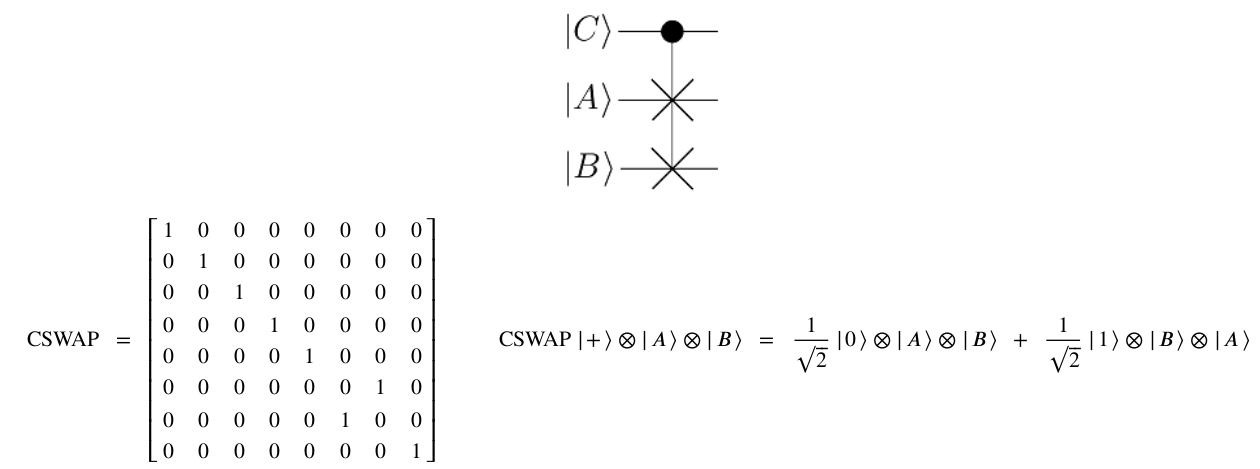

Just as the name implies, the CSWAP gate implements a SWAP gate between two qubits if and only if the control qubit is in the |1⟩ state. This 3-qubit gate already comes standard with our qiskit library, and can be seen in the cell of code below:

In [10]:
a = QuantumRegister(1,name='a')
q = QuantumRegister(2,name='q')
qc= QuantumCircuit(a,q)

qc.h( a[0] )
qc.x( q[1] )

print('____ Before CSWAP ____')
job =   execute(qc, S_simulator)
result =  job.result()
print(result.get_statevector())

qc.cswap( a[0], q[0], q[1] )

print('\n____ After CSWAP ____')
job =   execute(qc, S_simulator)
result =  job.result()
print(result.get_statevector())



____ Before CSWAP ____


/var/folders/jc/kp4xhk952mn13_g04my_yqwh0000gn/T/ipykernel_2938/1370247533.py:9: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job =   execute(qc, S_simulator)


Statevector([0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j, 0.70710678+0.j,
             0.        +0.j, 0.        +0.j],
            dims=(2, 2, 2))

____ After CSWAP ____
Statevector([0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j, 0.70710678+0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j],
            dims=(2, 2, 2))


/var/folders/jc/kp4xhk952mn13_g04my_yqwh0000gn/T/ipykernel_2938/1370247533.py:16: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job =   execute(qc, S_simulator)


With this CSWAP gate now in hand, we're ready to discuss the SWAP Test. As we shall see, the addition of the extra control qubit, in conjunction with CSWAP, is what is going to allow us to extract the scalar value needed for our similarity measure. Below is the complete quantum circuit for the SWAP Test:

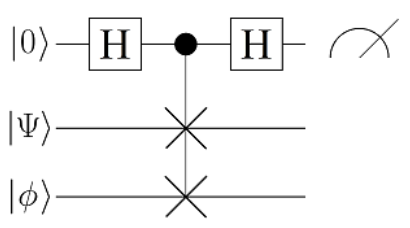

Simple and effective, the SWAP Test only requires three quantum gates (the CSWAP gate is actually composed of more gates however) and a measurement to determine the similarity between the states $|Ψ⟩$ and $|Φ⟩$. But in order to fully understand how this quantum circuit works, we will need to do a bit of math dissecting, shown in the steps below for a SWAP Test on the states $|{A}⟩$ and $|{B}⟩$.

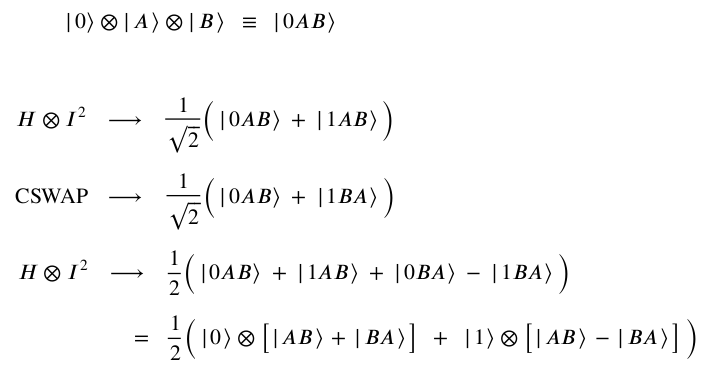

Now we come to the final step, which is analyzing the result of our measurement on the control qubit. As shown in the last line of the derivation above, the
final result of our SWAP Test circuit has put our quantum system into a state where the two components of the control qubit are tied to different quantities
composed of $|{A}⟩$ and $|{B}⟩$. More specifically, we have:

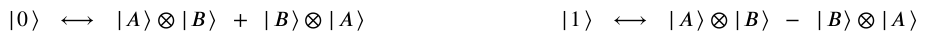

The key to interpreting this quantum state lies in the probability with which we can expect to measure our control ancilla qubit in the |0⟩ state:

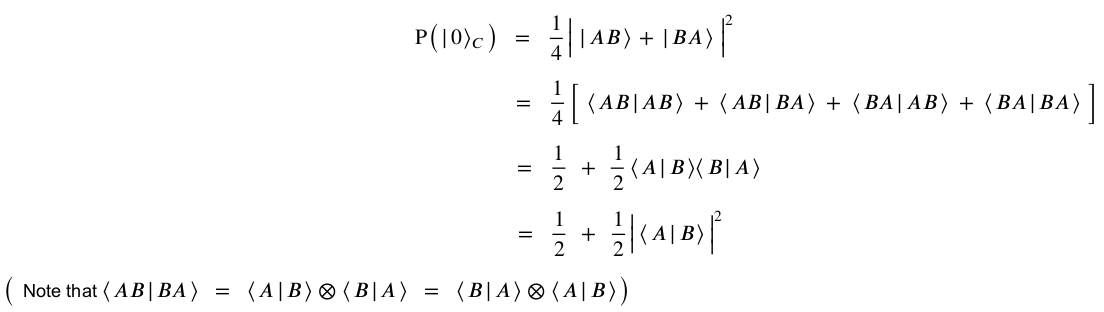

The full derivation above is by no means easy to digest at first, so I encourage you to spend some extra time fully grasping how the SWAP Test circuit leads to this final result. In summary, the last line shown above holds our final answer, giving us a clear relationship between the expected measurement rate of our control ancilla qubit and the inner product ⟨A|B⟩. Thus, through the measurement of the ancilla qubit, we can extrapolate the similarity between the states |A⟩ and |B⟩. The story doesn't quite end here however, but first let's see the SWAP Test in action with a coding example:

In [11]:
q = QuantumRegister(3,name='q')
c = ClassicalRegister(1,name='c')
qc= QuantumCircuit(q,c,name='qc')

qc.h( q[1] )
qc.x( q[2] )
qc.barrier()

#------------------------------   The SWAP Test
qc.h( q[0] )
qc.cswap( q[0], q[1], q[2] )
qc.h( q[0] )
qc.measure( q[0], c[0] )

#-------------------------------

M_simulator = Aer.backends(name='qasm_simulator')[0]

job = execute(qc,M_simulator,shots=1000)
result = job.result()
result.get_counts(qc)

/var/folders/jc/kp4xhk952mn13_g04my_yqwh0000gn/T/ipykernel_2938/905383793.py:19: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(qc,M_simulator,shots=1000)


{'1': 265, '0': 735}

/Users/diksha/opt/anaconda3/envs/qiskit_0.46/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


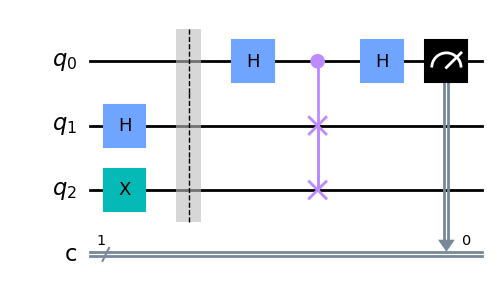

In [12]:
qc.draw('mpl')

The cell of code above performs a SWAP Test between the following two states:

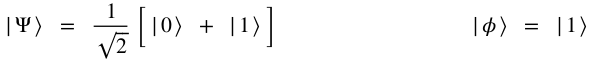

which results in the following inner product:

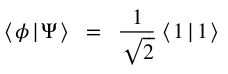

Thus, when we run our SWAP Test, we should find that the probability of measuring the |0⟩ state is:

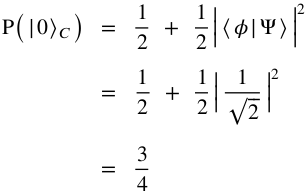

Comparing this result to our cell of code above, we do indeed find the |0⟩ state with a 75% probability!

In our next example, we're going to show how to extend the SWAP Test to states of more than one dimension. A simple enough task, all we need to do is add additional CSWAP gates to our cicuit, properly lining up which qubits to swap:

In [13]:
a = QuantumRegister( 1, name='a' )
q1 = QuantumRegister( 2, name='q1' )
q2 = QuantumRegister( 2, name='q2' )
c = ClassicalRegister( 1, name='c' )
qc = QuantumCircuit( a, q1, q2, c )

# ------------------------------

qc.h( q1[0] )
qc.h( q1[1] )
qc.x( q2[1] )

qc.barrier()

# -------------------------------- 2-Qubit SWAP Test

qc.h( a[0] )
qc.cswap( a[0], q1[0], q2[0] )
qc.cswap( a[0], q1[1], q2[1] )
qc.h( a[0] )
qc.measure(a,c)

#--------------------------------

M_simulator = Aer.backends(name='qasm_simulator')[0]

job = execute(qc,M_simulator,shots=8000)
result = job.result()

print('\n___ Measurement Probabilities on the Control Qubit ___')
print(result.get_counts(qc))




___ Measurement Probabilities on the Control Qubit ___
{'0': 4928, '1': 3072}


/var/folders/jc/kp4xhk952mn13_g04my_yqwh0000gn/T/ipykernel_2938/2816298090.py:27: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(qc,M_simulator,shots=8000)


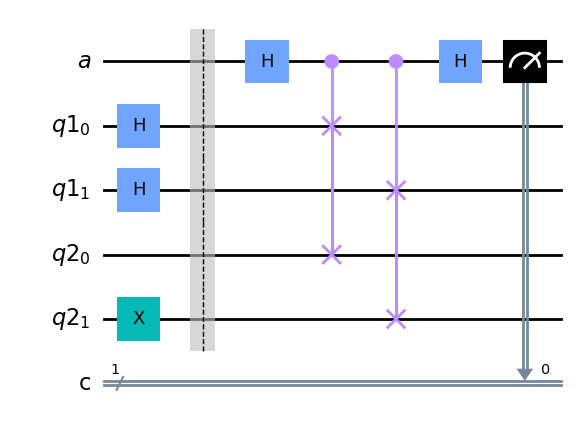

In [14]:
qc.draw('mpl')

In the example above, the two states which we are applying the SWAP test to are:

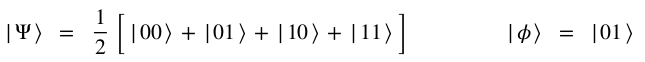

which should result in the following inner product and corresponding SWAP Test probability:

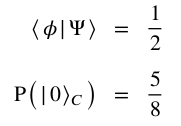

Returning now to the results of our code, sure enough we find roughly 5000 out  of the total 8000 measurements to be in the |0⟩ state, confirming that our SWAP Test has indeed worked. Taking a closer look at the code, you can see that we were able to implement our 2-dimensional CSWAP gate by using two individual CSWAPS stemming from the same control qubit (no need to bring in any additional ancilla qubits like we did for our higher order CCNOT implementations).


Visually, we can implement a CSWAP gate between any two N -dimensional states by simply applying a series of N CSWAP gates:

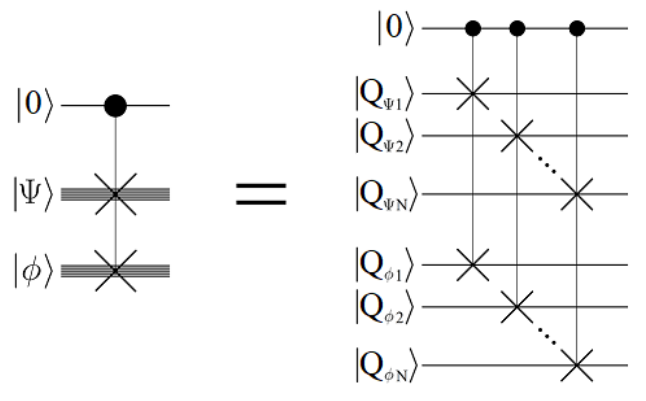

## **Quantum Subroutine: Distance Calculation**

With the SWAP Test now in our toolbox for evaluating the inner product between two quantum states, we're ready to jump into our second quantum subroutine for this lesson: calculating distances. As we already mentioned earlier, computing Euclidean distances is the bottleneck of our $\cal{k}$-means algorithm, so now we're going to see how we might improve $\cal{k}$-means through the use of our quantum computer. 

In fact, we're going to take a look at two methods for calculating distances, each with their own pros and cons. Ultimately however, only one of them will be used in our final $\cal{Q}$-means clustering algorithm, for reasons which will become clear after comparing the requirements necessary for each technique.

### **DistCalc 1: Euclidean Distance**

The first distance calculating subroutine (which we are nicknaming DistCalc) that we will be studing was put forth by <!-- [Text](link) -->
[Seth Lloyd, Masoud Mohseni, Patrick Rebentrost](https://arxiv.org/abs/1307.0411 "Optional Title") and demonstrates how one can use quantum states to compute the quantity $|𝐴 − 𝐵|^{2}$ , the Euclidean distance squared between two vectors 𝐴⃗ and 𝐵⃗ . And as we have already discussed, this is exactly the quantity that gets minimized when we compute centroids using the means.For the purpose of assigning data points to the nearest clusters, once $|𝐴 − 𝐵|^{2}$ has been computed, taking the square root for the Euclidean distance between 𝐴⃗ and 𝐵⃗ is simple enough. 

To begin this DistCalc subroutine, our first task is the encoding of the two vectors 𝐴⃗ and 𝐵⃗ as quantum states. Specifically, we want to represent the components of each vector as the different elements of our quantum state:

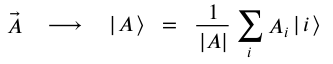

For example, suppose we wanted to encode the point 𝐴⃗ = [ 3,4 ] as a quantum state:

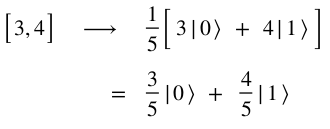

As we can see by the way in which we've defined our encoding, we're always guaranteed to produce a normalized quantum state, which is good. The only
drawback however is that points which are a constant multiple of each other get mapped to the same quantum state. For example:

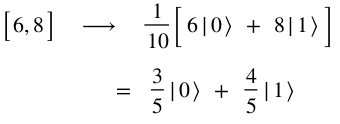

Even though we can't represent every data point as a unique quantum state, we shall see that this turns out to be a non-issue, one that can be corrected for
with a single classical calculation. The bigger challenge lies in the quantum states themselves, as preparing arbitrary amplitudes is typically a tough ask of
quantum computers. Luckily for us, Qiskit comes with the function **initialize()** already built into its simulator. So long as we provide Qiskit with a normalized
vector, it will create the corresponding quantum state to the nearest accuracy it can:

In [15]:
q = QuantumRegister(1)
qc= QuantumCircuit(q)
A = [ 3/5, 4/5 ]
qc.initialize( A, [q[0]] )

job =   execute(qc, S_simulator)
result =  job.result()
print(result.get_statevector())

Statevector([0.6+0.j, 0.8+0.j],
            dims=(2,))


/var/folders/jc/kp4xhk952mn13_g04my_yqwh0000gn/T/ipykernel_2938/2816012523.py:6: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job =   execute(qc, S_simulator)


Now that we can prepare arbitrary quantum states via initialize(), the next step in our subroutine will be to produce the following two quantum states:

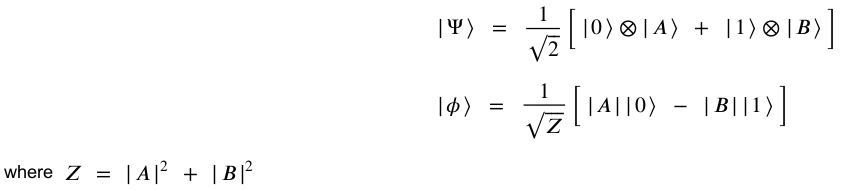

Now, let's discuss something interesting about the states $|Ψ⟩$ and $|Φ⟩$ above: they are not of the same dimension. Suppose we are trying to calculate the distance between two 𝑁 -dimensional vectors 𝐴⃗ and 𝐵⃗ . Encoding the states |𝐴⟩ and |𝐵⟩ will require 𝑂($log_2 𝑁$) qubits, while |𝜙⟩ is always a single qubit state. Thus in total, the preparation of these two states will require 𝑂($log_2 𝑁$ ) +1 qubits to create. And the reason we've made a point to highlight their dimensional difference is because the next step in the subroutine will be to perform the SWAP Test between them, which will ultimately gives us our distance squared:

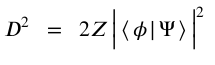

We just jumped quite a few steps, but it's worthwhile to have seen the final answer first as we now backtrack through the math. Keeping in mind that so long as we are able to extract $| ⟨𝜙|Ψ⟩ |^{2}$ using our quantum computer, then the following derivation steps confirm the validity of our DistCalc
subroutine:

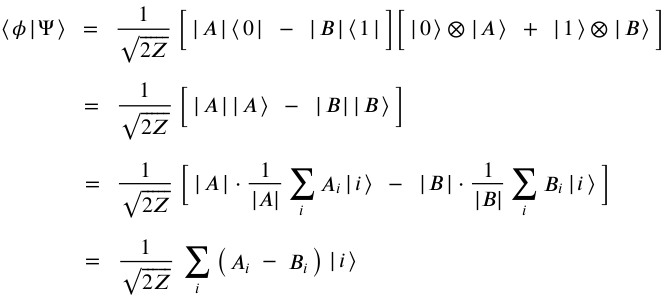

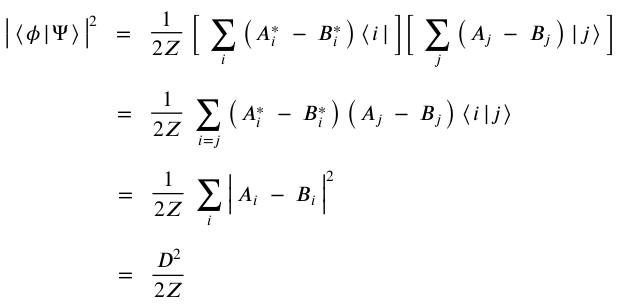

Simple and powerful, this subroutine can be best summarized as the encoding
of 𝐴⃗ and 𝐵⃗ into two quantum states, whose inner product produces the vector 𝐴⃗ − 𝐵⃗ as a new state, which in turn allows us to compute their distance via
the SWAP Test. But now here comes the tricky part. Because |Ψ⟩ and |𝜙⟩ are of different dimensions, what does it mean to perform a SWAP Test between them?

In our previous two implementations of the SWAP Test, for quantum states composed of either single or multiple qubits, the goal was to evaluate the inner
⟨𝐴|𝐵⟩ product, which mathematically was a scalar quantity because and were of the same dimensionality. And as we've shown, we can use repeat measurements to approximate this quantity via the inner product squared resulting from our SWAP Test.

But now if we consider the case where |A⟩ and |B⟩ of different dimensions, this in turn means that the inner product ⟨𝐴|𝐵⟩ is no longer a scalar, as demonstrated in the derivation above. Furthermore, since our SWAP Test is only able to tell us the value of $|𝐴 − 𝐵|^{2}$ , which is always a scalar, this means that the information pertaining to the leftover state from ⟨𝐴|𝐵⟩ is lost. If working with the state produced from the inner product of |Ψ⟩ and |𝜙⟩ was necessary for our distance calculating subroutine, then
unfortunately the SWAP Test would be of no use to us. Luckily however, the scalar quantity $| ⟨A|B⟩ |^{2}$ is all we need!

In following the derivation steps above, which form the basis for why the quantity $|⟨𝜙|Ψ⟩|^{2}$ can in turn be used for computing Euclidean distances, there is one small detail we must revisit before we can construct our circuit. In computing the inner product ⟨𝜙|Ψ⟩ , notice that in the derivation we chose to carry out this operation between |𝜙⟩ and the first qubit within |Ψ⟩ , the one responsible for holding the superposition between the states |𝐴⟩ and |𝐵⟩ .
Mathematically, we could have chosen to enforce this inner product with any of the qubits that make up |Ψ⟩ , which means that the quantity ⟨𝜙|Ψ⟩ can
have up to 𝑄 possible interpretations, where 𝑄 is the number of qubits making up the state |Ψ⟩ . Consequently, this means that there are 𝑄 different results
we could obtain from our SWAP Test for evaluating $|⟨𝜙|Ψ⟩|^{2}$ , but only one of them will correctly complete our Euclidean distance subroutine.


In order to correctly pick out the inner product ⟨𝜙|Ψ⟩ we want, it turns out that all we need to do is enforce the SWAP Test between the two qubits whose
inner product we are interested in. For our DistCalc subroutine here then, this means that we will be able to extract the $|⟨𝜙|Ψ⟩|^{2}$ quantity we are interested in with the use of a single CSWAP gate between the qubit containing the state |𝜙⟩ and the first qubit within |Ψ⟩ . It may come as a surprise that we can effectively evaluate an inner product between $2$ and $2^{Q}$ dimensional states the same way as between two single qubit states, so consider the derivation below which demonstrates how the choice in which qubits to swap determines the result of the SWAP Test:

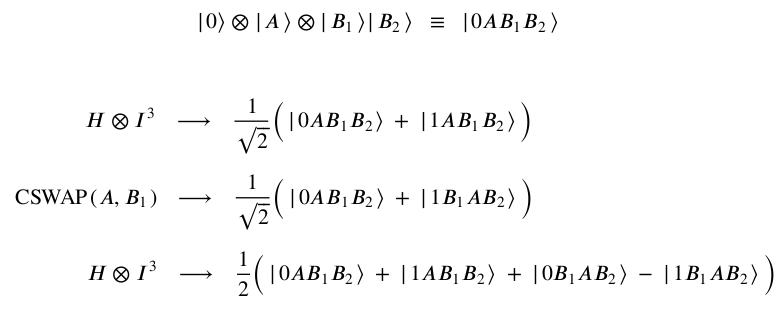

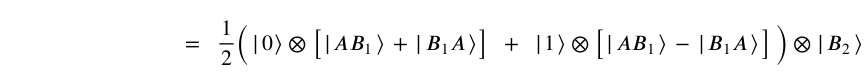

Compare the steps of the SWAP Test shown above with those from the previous section (between two single qubit states |𝐴⟩ and |𝐵⟩ ). Note how we arrive
at an identical result between the qubits $A$ and $𝐵_1$ , despite system |𝐵⟩ being composed of two qubits. If we now go ahead and compute the probability of
measuring the |0⟩ state on our control qubit, we will find that our measurement result correctly evaluates the desired inner product between qubits $A$ and $𝐵_1$ :

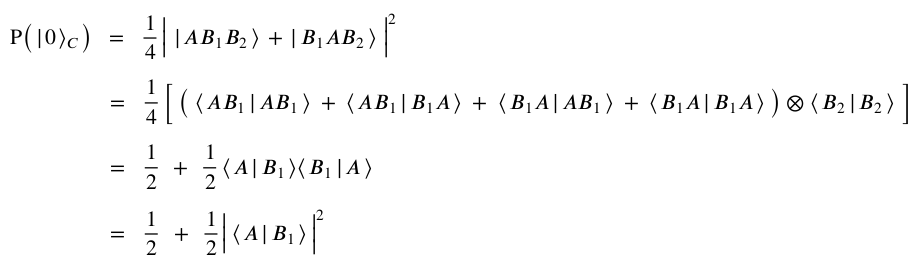

The important concept here is the way in which the state of qubit $𝐵_2$ goes through the SWAP Test completely unaffected, causing the final measurement on
the control qubit to exclusively extract the information of ⟨A| $𝐵_1$ ⟩. From a quantum circuit perspective this should make sense, as the only operations ever
applied to $| 𝐵_2 ⟩$ are Identity gates in the derivation above. Based on this new result from the SWAP Test, hopefully it is clear that the derivation above could
be applied to the inner product of ⟨$A| 𝐵_2$ ⟩ as well by simply changing the CSWAP gate. And more generally, so long as one properly lines up the correct
qubits for the desired inner product via CSWAP gates, the SWAP Test can be used to compute the inner product between any two dimensionally mismatched
quantum states. To demonstrate this, below is the complete implementation of our DistCalc subroutine for computing the Euclidean distance between two
vectors 𝐴⃗ and 𝐵⃗ :

In [16]:
A = [1,0,-2,0]
B = [6,-4,0,0]
trials = 50000

#==============================

A_norm = 0
B_norm = 0
D = 0

for i in np.arange(len(A)):
  A_norm = A_norm + A[i]**2
  B_norm = B_norm + B[i]**2
  D = D + (A[i]-B[i])**2
D = m.sqrt(D)
A_norm = m.sqrt(A_norm)
B_norm = m.sqrt(B_norm)
Z = round( A_norm**2 + B_norm**2 )

#------------------------------

phi_vec = [A_norm/m.sqrt(Z),-B_norm/m.sqrt(Z)]
psi_vec = []
for i in np.arange(len(A)):
  psi_vec.append( (A[i]/A_norm) /m.sqrt(2) )
  psi_vec.append( (B[i]/B_norm) /m.sqrt(2) )

#==============================

a = QuantumRegister(1,name='a')
q = QuantumRegister(4,name='q')
c = ClassicalRegister(1,name='c')
qc= QuantumCircuit(a,q,c)
qc.initialize( phi_vec, [q[0]])
qc.initialize( psi_vec, [q[1:4]] )

#------------------------------ The SWAP Test

qc.h( a[0] )
qc.cswap( a[0], q[0], q[1] )
qc.h( a[0] )
qc.measure(a,c)
#------------------------------

M_simulator = Aer.backends(name='qasm_simulator')[0]

job = execute(qc,M_simulator,shots=trials)
result = job.result()

M = result.get_counts(qc)

print('Euclidean Distance:',round(D,4))
print('\n DistCalc Distance:',round( m.sqrt((((M['0']/trials - 0.5)/0.5)*2*Z)),4) )

/var/folders/jc/kp4xhk952mn13_g04my_yqwh0000gn/T/ipykernel_2938/1725637558.py:47: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(qc,M_simulator,shots=trials)


Euclidean Distance: 6.7082

 DistCalc Distance: 6.744


The code example above showcases perhaps the most appealing aspect of this  DistCalc subroutine: the ability to mathematically deliver on the exact distance between two vectors 𝐴 and 𝐵 . And if we continually increase the number of repeat measurements for better and better approximations to
$|⟨𝜙|Ψ⟩|^{2}$ , our final answer will similarly become a more accurate approximation to the true Euclidean distance. Additionally, notice in the example that we actually computed the distance between two 3-dimensional vectors 𝐴⃗ and 𝐵⃗ , demonstrating that this subroutine isn't limited to only working with vectors of length $2^{𝑁}$ .


In light of the successful code example above, showcasing that this subroutine can certainly be used as a replacement for distance calculating in our 𝑘-
means algorithm, we must now discuss its major shortcoming and why we won't be implementing it going forward. As we already alluded to at the beginning
of our discussion, the preparation of |𝜙⟩ and |Ψ⟩ is no easy task, especially when we start to consider higher dimensional vectors. The strict requirements on structure for these states is precisely why this subroutine is able to yield exact distance measures, but it is also a huge barrier for implementing this
technique on a real quantum computer.


Thus, our next DistCalc subroutine will look to trade distance accuracy for ease of execution, representing a
technique which is much more viable for current quantum computing technologies.

### **DistCalc 2: A Quantum Distance Measure**

If we return to our original motivation for studying the DistCalc subroutine above, it was to improve upon the "Assignment" step in our -means clustering
algorithm. Specifically, we were looking for a quantum subroutine which could quickly assess each data point and compute the closest centroid. Naturally
then, we gravitated towards a quantum algorithm which promised to deliver us the same quantity we would normally have computed classically: Euclidean
distance (or distance squared). But now suppose we could answer our question about nearest centroids **without** necessarily computing data point distances.
Sounds a bit counterintuitive, but in fact it's exactly how our next subroutine is going to determine "closeness" between data points.


In order for the $\cal{k}$-means algorithm to successfully advance through each iteration, the only requirement is that each data point gets properly sorted into the nearest cluster. Whether we meet this criteria via computing Euclidean distances, distances squared, or by some other means is irrelevant, so long as at the end of the day each data point finds its way into the correct cluster and we are satisfied with the result. And as you may now suspect, our next subroutine will perform the "some other means'' methodology for determining which cluster to assign each data point to. Essentially, we will once again be using SWAP Tests as our metric for closeness and data point assigning. But even though the quantity extracted from these SWAP Tests will have no direct connection to Euclidean distance, they will still serve the purpose of determining nearest centroids.


Just as before, in order to properly use our SWAP Test as a substitute metric for Euclidean distance, the critical element is the way in which we encode the
data into quantum states. For example, we've already seen one way in which to encode cartesian data points as quantum states:

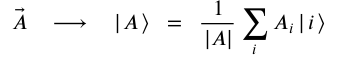

But now we must ask whether or not this encoding will serve our purpose for determining closeness between points. More specifically, what meaning can we
extract from a SWAP Test performed between two states |A⟩ and |B⟩ encoded in this way? Previously, we needed to embed the states |A⟩ and |B⟩ into |𝜙⟩ and |Ψ⟩ in order to obtain their distance. So let's now see what information we can extract from a SWAP Test between them directly:

In [17]:
def SWAP_Test( qc, control, q1, q2, classical, S ):
  '''
  Input: qc (QuantumCircuit) control (QuantumRegister[i]) q1 (QuantumRegister[i]) q2 (QuantumRegister[i]) classical (ClassicalRegister[i]) S (integer)
  Appends the necessary gates for 2-Qubit SWAP Test and returns the number of |0> state counts
  '''
  qc.h( control )
  qc.cswap( control, q1, q2 )
  qc.h( control )
  qc.measure( control, classical )
  D = {'0':0}
  M_simulator = Aer.backends(name='qasm_simulator')[0]
  job = execute(qc,M_simulator,shots=S)
  result = job.result()
  D.update( result.get_counts(qc) )
  return D['0']

In [18]:
Shots = 10000
Points = [ [-1,1], [3,4], [7,7], [6,8] ]
Norm_Points = []

for p in np.arange( len(Points) ):
  Norm_Points.append( Points[p]/np.linalg.norm(Points[p]) )

#==================================================

for p2 in np.arange( len(Norm_Points)-1 ):
  q = QuantumRegister(3)
  c = ClassicalRegister(1)
  qc= QuantumCircuit(q,c)
  qc.initialize( Norm_Points[int(p2)], [q[1]] )
  qc.initialize( Norm_Points[-1], [q[2]] )

  #--------------------------------------------------

  IP = SWAP_Test( qc, q[0], q[1], q[2], c[0], Shots )
  print('\nComparing Points: ',Points[p2],'&',Points[-1],'\n',IP,'|0>',Shots-IP,'|1>')

/var/folders/jc/kp4xhk952mn13_g04my_yqwh0000gn/T/ipykernel_2938/2064237573.py:12: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(qc,M_simulator,shots=S)



Comparing Points:  [-1, 1] & [6, 8] 
 5006 |0> 4994 |1>

Comparing Points:  [3, 4] & [6, 8] 
 10000 |0> 0 |1>

Comparing Points:  [7, 7] & [6, 8] 
 9912 |0> 88 |1>


The example above uses the SWAP Test to compare three different points to [6,8]. 𝐒𝐖𝐀𝐏_𝐓𝐞𝐬𝐭 handles all of the steps for a 1-qubit SWAP Test and returns the number of |0⟩ counts. Starting from the top then, we can
see that the point [ -1,1 ] results in the highest number of |1⟩ counts, signally that the quantum states representing these two points have the smallest
overlap (practically completely orthogonal). At first glance this looks like a potentially positive result, reflecting the fact that [ -1,1 ] is quite distant from [ 6,8 ]. However, looking at the next two results confirms that our SWAP test isn't giving us a desirable metric.


If the goal of the example above was to determine which centroid is closest to our data point [ 6,8 ], then the results of the SWAP test would suggest that
[ 3,4 ] is a perfect match, beating out [ 7,7 ]. Obviously we know this is incorrect, thus signaling an issue with our quantum approach. Mathematically, it
shouldn't be too hard to spot where the problem lies, as evidenced by the code below:

In [19]:
Shots = 10000
Points = [ [2,3], [4,6], [8,12], [12,18] ]
Norm_Points = []

for p in np.arange( len(Points) ):
  Norm_Points.append( Points[p]/np.linalg.norm(Points[p]) )

#==================================================

for p2 in np.arange( len(Norm_Points)-1 ):
  q = QuantumRegister(3)
  c = ClassicalRegister(1)
  qc= QuantumCircuit(q,c)
  qc.initialize( Norm_Points[int(p2)], [q[1]] )
  qc.initialize( Norm_Points[-1], [q[2]] )

  #--------------------------------------------------

  IP = SWAP_Test( qc, q[0], q[1], q[2], c[0], Shots )
  print('\nComparing Points: ',Points[p2],'&',Points[-1],'\n',IP,'|0>',Shots-IP,'|1>')

/var/folders/jc/kp4xhk952mn13_g04my_yqwh0000gn/T/ipykernel_2938/2064237573.py:12: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(qc,M_simulator,shots=S)



Comparing Points:  [2, 3] & [12, 18] 
 10000 |0> 0 |1>

Comparing Points:  [4, 6] & [12, 18] 
 10000 |0> 0 |1>

Comparing Points:  [8, 12] & [12, 18] 
 10000 |0> 0 |1>


At the beginning of our fist DistCalc discussion, we pointed out that points which were a constant multiple of each other resulted in the same quantum state.
And while the complete subroutine could correct for this limitation using a quick classical computation to produce the desired final distance, unfortunately the SWAP Test alone cannot do the same. Never fear however, as the examples above are only meant to demonstrate the importance of choosing the correct mapping of classical data to quantum. In order for our SWAP Test to be an effective measure of distance, we will need to take care in the way we encode our classical space into quantum states.

## **Mapping to the Bloch Sphere**

In light of the examples we just saw, we're now ready to discuss the way in which we will be effectively computing centroid distances using the SWAP Test.
Essentially, our goal will be to map our 2D cartesian space of data points onto the surface of a Bloch Sphere:

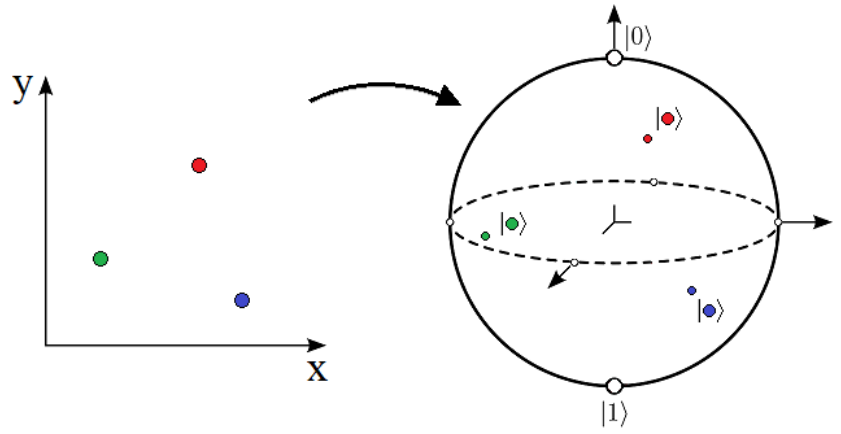

As represented in the illustration above, the conceptual goal is that we can use the surface of the Bloch Sphere as a space to mimic the Euclidean distances
of our original 2D data space. Keeping in mind that the SWAP Test is our determining metric, we ideally then would like to choose a mapping such that points which are closer together have higher inner product overlaps, and subsequently distant points are more orthogonal. However, there are many possible ways we can map our data to meet these criteria, some more fitting to certain spaces of data than others. In the coming examples we're going to demonstrate two such choices, but it is important to keep in mind that the best way to encode one's data into quantum states is a case by case basis.

### **Unsymmetric Mapping**

When we picture using the Bloch Sphere as our new data space, a natural change in metrics is to transform from the cartesian coordinate system (x, y) to
polar angles (θ,Φ). Once we have the polar coordinates for our data point, creating the corresponding quantum state is as simple as using the
$U_{3}$ gate:

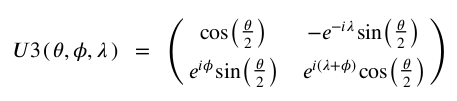

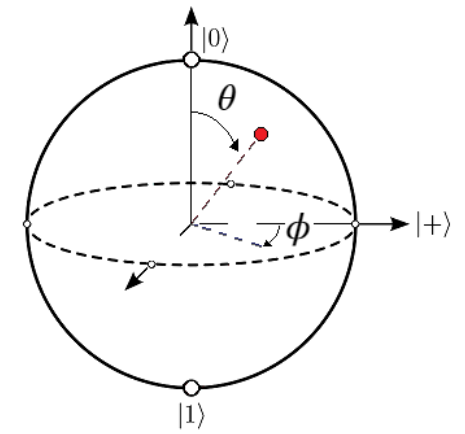

Compare the way in which we are able to prepare our states for the SWAP Test here via the $U_{3}$
gate with |Φ⟩ and |Ψ⟩ from before. Whereas the previous DistCalc subroutine was reliant on elaborate state preparations, requiring complex circuit designs, here we are able to initialize our new subroutine with the use of a single gate! With the preparation of our quantum states easily taken care of, all that's left is to decide on our mapping: ( x,y ) →
( θ,Φ ) (in principle we could also include λ in our encoding, but for now we will just work with θ and Φ). As our first example, let's take a look at a data space which spans from 1-1 
to in both x and y, and maps to the polar coordinates of the Bloch Sphere as follows:

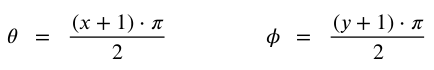

Using the mapping above, we are guaranteed that every point within our allowed data space is uniquely mapped to a single location on the Bloch Sphere. For
reasons we've already seen, this 1-to-1 mapping is an important quality that we will be enforcing from here on (no longer will we allow multiple data points to
map to the same quantum state). Now, before we dissect the pros and cons of the mapping we've chosen, let's see it in action first. The two code examples
below demonstrate how our transformation performs at determining which centroid a central data point is closest to:

/var/folders/jc/kp4xhk952mn13_g04my_yqwh0000gn/T/ipykernel_2938/4141782135.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


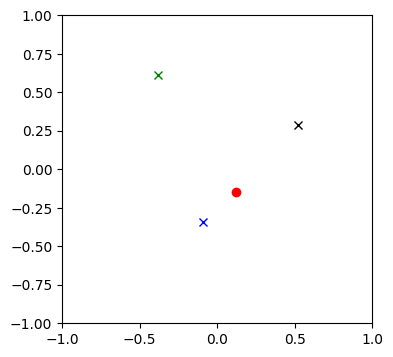

In [20]:
Point = [ 0.12, -0.15 ]
Centroids = [ [-0.38,0.61] , [-0.09,-0.34] , [0.52,0.29] ]
#-----------------------

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
ax.axis([-1,1,-1,1])
fig.show()

#-----------------------

plt.plot(Point[0], Point[1], 'ro')
markers = ['gx','bx','kx']
for c in np.arange( len(Centroids) ):
  plt.plot(Centroids[c][0], Centroids[c][1], markers[c])

As we can see in the figure above, our central data point (red circle) is closest to the blue centroid. Thus, the ideal output from our quantum subroutine will be
to classify this data point as belonging to the corresponding blue cluster. Let's see how we do:

In [22]:
Shots = 10000
Point = [ 0.12, -0.15 ]
Centroids = [ [-0.38,0.61] , [-0.09,-0.34] , [0.52,0.29] ]
Bloch_Point = [ (Point[0]+1)*m.pi/2, (Point[1]+1)*m.pi/2 ]
Bloch_Cents = []
for c in np.arange( len(Centroids) ):
  Bloch_Cents.append( [ (Centroids[c][0]+1)*m.pi/2, (Centroids[c][1]+1)*m.pi/2 ] )

#====================================

colors = ['Green','Blue','Black']
for c2 in np.arange( len(Bloch_Cents) ):
  q = QuantumRegister(3)
  c = ClassicalRegister(1)
  qc= QuantumCircuit(q,c)
  qc.u( Bloch_Point[0], Bloch_Point[1], 0, [q[1]] )
  qc.u( Bloch_Cents[c2][0], Bloch_Cents[c2][1], 0, [q[2]] )

#--------------------------------------------------

  IP = SWAP_Test( qc, q[0], q[1], q[2], c[0], Shots )
  print('\n\nComparing Points: ',Centroids[c2],'& ',Point,'(',colors[c2],' Centroid )\n\n',IP,'|0>',Shots)



Comparing Points:  [-0.38, 0.61] &  [0.12, -0.15] ( Green  Centroid )

 8019 |0> 10000


Comparing Points:  [-0.09, -0.34] &  [0.12, -0.15] ( Blue  Centroid )

 9749 |0> 10000


Comparing Points:  [0.52, 0.29] &  [0.12, -0.15] ( Black  Centroid )

 9150 |0> 10000


/var/folders/jc/kp4xhk952mn13_g04my_yqwh0000gn/T/ipykernel_2938/2064237573.py:12: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(qc,M_simulator,shots=S)


Just like we wanted, our SWAP Test results are telling us that the closest centroid to our data point is the blue cluster! Even better yet, we can see that the
next closest centroid is black, and the differences in |0⟩
counts between the three results is suggestively similar to differences in distances shown in the
figure. Having now seen that our choice in mapping produces the desired results, we can now dive a bit deeper into why it works. For starters, let's take a
look at the bounds of our data space, and the corresponding limits on our polar angles:

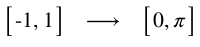

which when translated into the quantum states produced from the $U_{3}$ gate gives us:

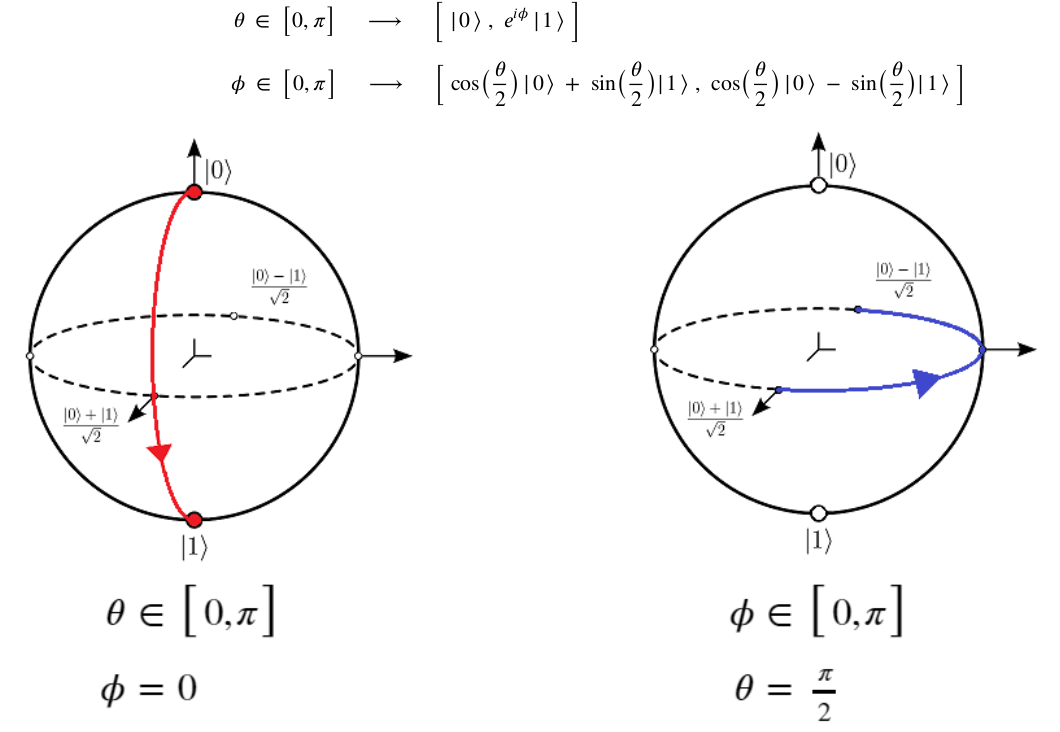

As shown in the illustrations above, the bounds of our mapping result in 180° rotations along the surface of the Bloch Sphere. Consequently, these limits
result in perfectly orthogonal states for θ (for any Φ), and for Φ when θ = $\frac{Π}{2}$
(the |+⟩
and \-⟩
states along the equator). Translating these results back to
our original data space, it means that points along the x boundaries will be interpreted as maximally distant (regardless of their y component), but only one
instance of points along the y boundaries will be maximally distant (for the case where x = 0).

Based on the results just discussed, it should be apparent that our mapping is asymmetric in its treatment of x and y, which can be traced to the asymmetric
way in which Θ and ϕ influence the quantum state. Technically Θ and ϕ both control the position of our state on the Bloch Sphere equally (the amount by
which we rotate in each polar direction), but Θ dictates the amplitude difference between the |0⟩ and |1⟩ , while ϕ controls the phase difference. Ultimately, this difference in influence impacts the way in which our SWAP Test interprets the distance between points. To visualize this difference, the cell of code below displays the overlap (inner product) produced from the SWAP Test of a single point with every other point in the data space. As a first demonstration, let's see all of the the inner products produced from our example point from earlier. The cell of code below uses a function called **Heatmap** to create a 2D display of the full inner product space:

In [23]:
def Heatmap(data, show_text, show_ticks, ax, cmap, cbarlabel, **kwargs):
  '''
  Input: data (array) show_text (Bool) show_ticks (Bool) ax (Matplotlib subplot) cmap (string) cbarlabel (string)
  Takes in data and creates a 2D Heatmap
  '''
  valfmt="{x:.1f}"
  textcolors=["black", "white"]
  threshold=None
  cbar_kw={}
  #----------------------------
  if not ax:
    ax = plt.gca()
  im = ax.imshow(data, cmap=cmap, **kwargs)
  cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
  cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
  ax.grid(which="minor", color="black", linestyle='-', linewidth=1)

  if( show_ticks == True ):
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.tick_params(which="minor", bottom=False, left=False)
  if threshold is not None:
    threshold = im.norm(threshold)
  else:
    threshold = im.norm(data.max())/2.

  kw = dict(horizontalalignment="center", verticalalignment="center")

  if isinstance(valfmt, str):
    valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
  if( show_text == True ):
    for i in range(data.shape[0]):
      for j in range(data.shape[1]):
        kw.update(color=textcolors[int(im.norm(data[i, j]) < threshold)])
        text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)

/var/folders/jc/kp4xhk952mn13_g04my_yqwh0000gn/T/ipykernel_2938/2064237573.py:12: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(qc,M_simulator,shots=S)


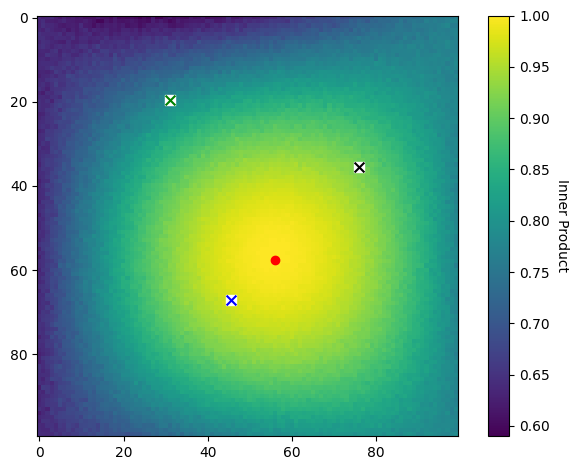

In [25]:
size = 100
Shots = 10000
Data_Space = [-1,1,-1,1]
Point = [0.12,-0.15] # Example Point
t = (Point[0]+1)*m.pi/2
p = (Point[1]+1)*m.pi/2
OL_grid = np.zeros(shape=(size,size))

#========================================================

for x in np.arange(size):
  t2 = (( (-1 + 2*(x/size)) + 1) * m.pi / 2)
  for y in np.arange(size):
    p2 = (( (-1 + 2*(y/size)) + 1) * m.pi / 2)
    #---------------------------------
    q = QuantumRegister( 3, name='q' )
    c = ClassicalRegister( 1, name='c' )
    qc= QuantumCircuit( q,c, name='qc' )
    qc.u( t, p, 0, q[1] )
    qc.u( t2, p2, 0, q[2] )

    #---------------------------------

    IP = SWAP_Test( qc, q[0], q[1], q[2], c[0], Shots )
    if( IP < 5000 ):
      IP = 5000
    OL_grid[int(size-y-1),int(x)] = m.sqrt((1.0*IP/Shots-0.5)*2)
#========================================================
fig, ax = plt.subplots()
show_ticks = False
show_text = False
Heatmap(OL_grid, show_text, show_ticks, ax, "viridis", "Inner Product")
plt.plot((Point[0]+1)*size/2, size-(((Point[1]+1))*size/2), 'ro')
Centroids = [ [-0.38,0.61] , [-0.09,-0.34] , [0.52,0.29] ]
colors = ['green','blue','black']
for c in np.arange(len(Centroids)):
  plt.scatter((Centroids[c][0]+1)*size/2, size-((Centroids[c][1]+1)*size/2), color='white', marker='s', s=50)
  plt.scatter((Centroids[c][0]+1)*size/2, size-((Centroids[c][1]+1)*size/2), color=colors[c], marker='x', s=50)
fig.tight_layout()
plt.show()

The plot above illustrates the inner product landscape associated with the point
[ 0.12,-0.15 ] . Using the gradient scale on the right side as our reference for
the percentage of |0⟩ state measurements, we can once again see the order in which the SWAP Test will pick out centroid distances: blue, black, green.
Looking at the overall shape of the inner product landscape above, the way in which the values appear to be radially decreasing around our point in question
(red circle) is very promising for our quantum metric to replace Euclidean distance. As we noted earlier, so long as the SWAP Test can correctly distinguish closer and further data points, it doesn't matter whether or not our quantum metric has any direct relation to Euclidean distance. However, despite looking promising, a closer examination of the plot above will start to reveal a few problematic areas:

1. If we focus on the 𝑥 boundaries, we see the same inner product value all along both edges (a bit hard to tell at first glance, but both sides are
monochromatic). This is telling us that our SWAP Test is interpreting all values along either boundary as equidistant.

2. Focusing now on the top left corner of the plot, it appears that the "furthest" point from our red dot is not [ -1,1 ], but rather something closer to
[ -0.8,1 ]. Consequently, points around this area of the data space will be incorrectly assessed for distance.

### **Symmetric Mapping**

Having now seen several examples of problems that can arise when mapping from Cartesian space to the Bloch Sphere, it's important to keep in mind that
there is no "perfect" transformation that will exactly mimic Euclidean distances (unless we're able to create ϕ
and Ψ
from earlier). We can design
mappings which preserve certain qualities over others, but ultimately every transformation will have its shortcomings. As an example, we'll now turn our
attention to a second transformation which is designed to be symmetric in x and y, preserving the quantity that opposite corners of our data space be
mapped to orthogonal states:

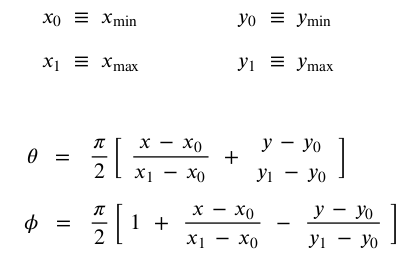

Taking a look at the transformation above, the first thing you should notice is that both 𝑥 and 𝑦 equally factor into the values for 𝜃 and 𝜙 , thus achieving our
desired symmetry. Additionally, the transformation is adaptable to any sized data space, even ones that differ in 𝑥 and 𝑦 size. This is a nice feature, but we
could have also done the same thing with our previous mapping. But most importantly, this transformation was designed specifically such that the four corners
of our data space get mapped to the follow states:

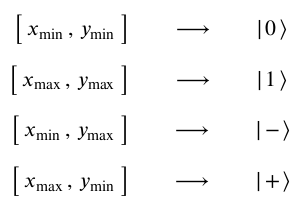

The four quantities shown above represent the central design to this choice in mapping, and will hold regardless of the min and max values for x and y. Let's see it in action:

In [26]:
def Bloch_State( p,P ):
  '''
  Input: p (array) P(array)
  Returns the corresponding theta and phi values of the data point p, according to min / max paramters of P
  '''
  x_min = P[0]
  x_max = P[1]
  y_min = P[2]
  y_max = P[3]
  theta = np.pi/2*( (p[0]-x_min)/(1.0*x_max-x_min) + (p[1]-y_min)/(1.0*y_max-y_min) )
  phi = np.pi/2*( (p[0]-x_min)/(1.0*x_max-x_min) - (p[1]-y_min)/(1.0*y_max-y_min) + 1 )
  return theta,phi

/var/folders/jc/kp4xhk952mn13_g04my_yqwh0000gn/T/ipykernel_2938/2064237573.py:12: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(qc,M_simulator,shots=S)


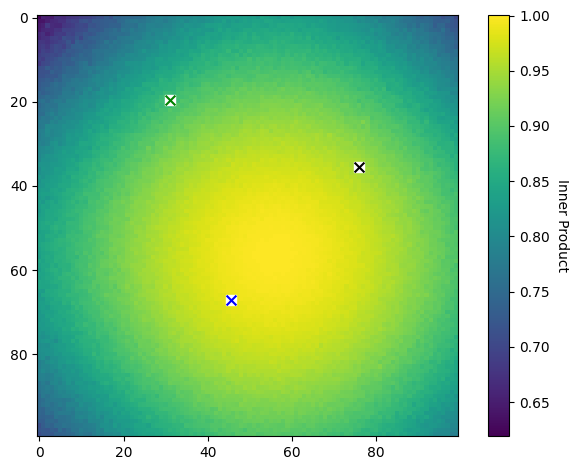

In [28]:
size = 100

#-------------------------------------------------------

Data_Space = [-1,1,-1,1]
Point = [0.12,-0.15] # Example Point
t,p = Bloch_State( Point, Data_Space )

#-------------------------------------------------------

OL_grid = np.zeros(shape=(size,size))

#========================================================

for x in np.arange(size):
  Xp = Data_Space[0] + (x/size)*(Data_Space[1]-Data_Space[0])
  for y in np.arange(size):
    Yp = Data_Space[2] + (y/size)*(Data_Space[3]-Data_Space[2])
    t2,p2 = Bloch_State( [Xp,Yp], Data_Space )
    #-----------------------------
    q = QuantumRegister( 3, name='q' )
    c = ClassicalRegister( 1, name='c' )
    qc= QuantumCircuit( q,c, name='qc' )
    qc.u( t, p, 0, q[1] )
    qc.u( t2, p2, 0, q[2] )

    #-------------

    IP = SWAP_Test( qc, q[0], q[1], q[2], c[0], Shots )
    if( IP < 5000 ):
      IP = 5000
    OL_grid[int(size-y-1),int(x)] = m.sqrt((1.0*IP/Shots-0.5)*2)

#========================================================

fig, ax = plt.subplots()
show_ticks = False
show_text = False
Heatmap(OL_grid, show_text, show_ticks, ax, "viridis", "Inner Product")
plt.plot((Point[0]-Data_Space[0])*size/(Data_Space[1]-Data_Space[0]), (Data_Space[3]-Point[1])*size/(Data_Space[3]-Data_Space[2]))
Centroids = [ [-0.38,0.61] , [-0.09,-0.34] , [0.52,0.29] ]
colors = ['green','blue','black']
for c in np.arange(len(Centroids)):
  plt.scatter((Centroids[c][0]+1)*size/2, size-((Centroids[c][1]+1)*size/2), color='white',marker='s', s=50)
  plt.scatter((Centroids[c][0]+1)*size/2, size-((Centroids[c][1]+1)*size/2), color=colors[c], marker='x', s=50)
fig.tight_layout()
plt.show()

Just like the previous transformation, the inner product space looks promising for the three centroids, correctly assessing the order of nearest to furthest as:
blue, black, green. So then, what can we say is different about this new mapping, and does it offer us any advantage over the old? For this particular
example, both transformations perform perfectly fine at distinguishing the three clusters, so neither one is really advantageous over the other. That being said,
let's investigate how this new transformation handles data points that were previously problematic, namely the boundaries.

We find out that with symmetric mapping both of the previous problems remedied, as well as achieving symmetry in x and y, it is fair to say that this second choice in mapping is a better suited
replacement for distance. And in the coming final example whereby we will implement the full $\cal{Q}$-means clustering algorithm, we will indeed be using this
transformation choice. But, despite the upgrade, we still must be aware of the potential cons of this mapping. For a square data space (the distance between $x_{min}$
and $x_{max}$
is the same as $y_{min}$
and $y_{max}$
) like the one in the above examples, this mapping is ideal, but not so for an asymmetric space. By preserving
that the four corners always map to the orthogonal states shown earlier, we can run into trouble if we are working with a data space that is noticeably longer
in either x or y.

# **Implementing 𝑄-Means Clustering**

With all of the tools for calculating distances via quantum states now in hand, it's time to construct our full $\cal{Q}$-means clustering algorithm. As a reminder, the motivation for using quantum states and inner products is to improve the "Assignment" step in our classical $\cal{k}$-means algorithm. Specifically, in the coding example to come, we will be replacing the **Update_Clusters** function with **Q_Update_Clusters** . Inside this new function will be our quantum system, using inner product values obtained from the SWAP Test via the symmetric mapping to determine the nearest centroid to each data point. Then after all of the data points have been sorted into their respective clusters, the remainder of the algorithm continues just as before. And without further ado, let's see our full $\cal{Q}$-means clustering algorithm in action:

In [31]:
def Q_Update_Clusters(D, CT, CL, DS, shots):
  '''
  Input:
  D (array)
  CT (array)
  CL (array)
  DS (array)
  shots (integer)
  Using all data points, Centroids, uses the SWAP Test to compute and return the new array of Clusters
  '''
  old_Clusters = []
  for c0 in np.arange(len(CL)):
    old_Clusters.append(CL[c0])
  Clusters = []
  for c1 in np.arange( len(CT) ):
    Clusters.append( [] )
  #------------------------------------------------
  for d in np.arange( len(D) ):
    closest = 'c'
    distance = 0
    t,p = Bloch_State( D[d], DS )
    for c2 in np.arange( len(Clusters) ):
      t2,p2 = Bloch_State( CT[c2], DS )
      q = QuantumRegister( 3, name='q' )
      c = ClassicalRegister( 1, name='c' )
      qc= QuantumCircuit( q,c, name='qc' )
      qc.u( t,p, 0, q[1] )
      qc.u( t2, p2, 0, q[2] )
      IP = SWAP_Test( qc, q[0], q[1], q[2], c[0], shots )
      if( IP > distance ):
        distance = IP
        closest = int(c2)
    Clusters[closest].append( D[d] )
  return Clusters,old_Clusters

/var/folders/jc/kp4xhk952mn13_g04my_yqwh0000gn/T/ipykernel_2938/3600481269.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/jc/kp4xhk952mn13_g04my_yqwh0000gn/T/ipykernel_2938/2064237573.py:12: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(qc,M_simulator,shots=S)


Clustering Complete: 50  Iterations


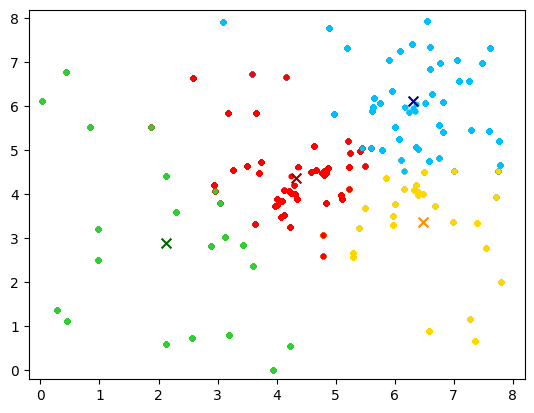

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.axis([-0.2,8.2,-0.2,8.2])
fig.show()
colors = ['red','limegreen','deepskyblue','gold']
colors2 = ['darkred','darkgreen','darkblue','darkorange']

#--------------------------------------------------------

n = 140
k = 4
shots = 500
Data_Space = [0,8,0,8]

#--------------------------------------------------------

Data = k_Data(k,n)
for d in np.arange(len( Data )):
  ax.scatter( Data[d][0], Data[d][1], color='black', s=10 )
fig.canvas.draw()
time.sleep(2)

#--------------------------------------------------------

Centroids = Initial_Centroids( k, Data )
Clusters = []
Clusters,old_Clusters = Q_Update_Clusters( Data, Centroids, Clusters, Data_Space, shots )
for c1 in np.arange(len(Clusters)):
  for c2 in np.arange( len( Clusters[c1] ) ):
    ax.scatter( Clusters[c1][c2][0],Clusters[c1][c2][1], color=colors[c1],s=10 )
  ax.scatter( Centroids[c1][0],Centroids[c1][1], color=colors2[c1], marker='x',s=50 )
  fig.canvas.draw()
  time.sleep(1)
time.sleep(2)

#--------------------------------------------------------

terminate = False
iters = 0
while( (terminate==False) and (iters<50) ):
  Centroids,old_Centroids = Update_Centroids(Centroids, Clusters)
  Clusters,old_Clusters = Q_Update_Clusters( Data, Centroids, Clusters, Data_Space, shots )
  Draw_Data( Clusters, Centroids, old_Centroids, fig, ax, colors, colors2 )
  terminate = Check_Termination( Clusters, old_Clusters )
  iters = iters + 1
print( 'Clustering Complete:',iters,' Iterations' )

As demonstrated above, our $\cal{Q}$-means algorithm is a success! By using the SWAP Test in combination with mapping each data point to the Bloch Sphere, we
were able to correctly sort each data point into the appropriate cluster (within some minor exceptions for borderline points).

Aside from achieving the same end goal, you may notice that running the cell of code above takes quite a bit longer than our classical code from earlier.
Although we made a point to highlight the potential speedup advantage gained from using $\cal{Q}$-means over $\cal{k}$-means, we can't ignore the fact that obtaining accurate inner product results requires the preparation and measurement of our quantum system numerous times. More accurate results require more measurements, which in turn means that we have a direct tradeoff in speed versus precision. Nevertheless, the demonstration of incorporating quantum into
our unsupervised learning algorithm is a noteworthy step towards the advancement of quantum computing!

# **References**
***

1. <!-- [Text](link) -->
[Least squares quantization in PCM - S. Lloyd](https://ieeexplore.ieee.org/document/1056489 "Optional Title")
2. <!-- [Text](link) -->
[Quantum algorithms for supervised and unsupervised machine learning - Seth Lloyd, Masoud Mohseni, Patrick Rebentrost](https://arxiv.org/abs/1307.0411  "Optional Title")
3. Fundamentals In Quantum Algorithms- Daniel Koch , Saahil Patel , Laura Wessing , Paul M. Alsing
4. <!-- [Text](link) -->
[q-means: A quantum algorithm for unsupervised machine learning](https://deepai.org/publication/q-means-a-quantum-algorithm-for-unsupervised-machine-learning "Optional Title")